# РЕТ-проект "Определение жанра по изображению обложки музыкального диска"

## Часть 2: обучение нейронной сети

**Цель проекта**: разработать модель, которая определит жанр музыкального альбома по изображению его обложки

**Шаги проекта:** 
- Подготовка данных для нейронной сети.
- Обучение нейронной сети.
- Расчет и сравнение метрик.
- Анализ финальной модели.
- Исследование/решение дополнительных задач.
- Подготовка отчета по исследованию.

## Библиотеки

In [103]:
#pip install fastai

In [104]:
#pip install --upgrade torch torchvision

In [514]:
#pip install pytesseract

In [687]:
#pip install sentence_transformers

In [ ]:
#pip install easyocr

In [ ]:
#pip install umap-learn

In [ ]:
#pip install umap-learn[plot]

In [460]:
#def my_import(pip_name):
#    try:
#        import pip_name
#    except:
#        pip install pip_name
#        import pip_name    

In [172]:
import fastai
from fastai.vision.all import *
import glob, os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import re
import requests

import torch
import glob
import pickle

import pytesseract
import easyocr

import pandas as pd
import multiprocessing

import umap

from PIL import Image

import umap.plot

from os import listdir
from os.path import isfile, join

from fastai.metrics import error_rate, accuracy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sentence_transformers import SentenceTransformer

from time import time
from tqdm import tqdm


from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights


from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline


from fastai.text.data import *
from fastai.text.all import *

## Подготовим данные для нейройнной сети

Определим путь до папки с файлами

In [3]:
path ='/home/jovyan/work/Master_Music/Data/images/'

In [4]:
files = get_image_files(path)
print('Всего изображенией для обработки:', len(files))

Всего изображенией для обработки: 7800


Выведем список папок с изображениями, название папок обозначает жанры

In [5]:
folder = '/home/jovyan/work/Master_Music/Data/images'
sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
sub_folders

['disco',
 'anime',
 'classical',
 'rap',
 'pop',
 'black metal',
 'jazz',
 'edm',
 'reggae',
 'country']

### Создадим таблицу с данными о полном пути к изображению и его жанром

In [6]:
p='/home/jovyan/work/Master_Music/Data/images/'
df=pd.DataFrame()

for i in sub_folders:
    temp_df=pd.DataFrame()
    temp=[]
    labels=[]
    f = os.path.join(p, str(i))

    for j in os.listdir(f):
        temp.append(j)
        labels.append(i)

    temp=['/home/jovyan/work/Master_Music/Data/images/' + str(i) + '/' + str(k) for k in temp]
    temp_df['path'] = temp
    temp_df['label'] = labels
    df=pd.concat([df, temp_df], axis=0)

In [7]:
df.head()

path  \
0  /home/jovyan/work/Master_Music/Data/images/disco/358c179f-2158-449f-838f-3c7ec136d8e2.png   
1  /home/jovyan/work/Master_Music/Data/images/disco/556fbf52-4ecb-4b2d-b0e8-1332459ede3e.png   
2  /home/jovyan/work/Master_Music/Data/images/disco/2e8b9d87-f45a-4c25-95dc-890381731397.png   
3  /home/jovyan/work/Master_Music/Data/images/disco/886dd611-cb45-4bf0-87f0-a904105b2ff6.png   
4  /home/jovyan/work/Master_Music/Data/images/disco/503073f1-3278-4132-b528-6c6dc4577696.png   

   label  
0  disco  
1  disco  
2  disco  
3  disco  
4  disco

Проверим правильность создания таблицы

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7800 entries, 0 to 1485
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    7800 non-null   object
 1   label   7800 non-null   object
dtypes: object(2)
memory usage: 182.8+ KB


In [208]:
df['label'].value_counts()

label
country        1486
anime          1189
classical       955
jazz            821
pop             803
edm             719
reggae          581
disco           468
black metal     450
rap             328
Name: count, dtype: int64

Проект выполняется локально с использованием CPU, проверим количество ядер

In [210]:
multiprocessing.cpu_count()

20

### Создадим загрузчик данных из датасета

Применим аугментацию: повороты, изменения насыщенности цвета, изменение размера и повороты

In [382]:
dls=ImageDataLoaders.from_df(df, 
                             path='/', 
                             valid_pct=0.2,
                          #   cbs='mixup',
                          #   label_delim=' ', 
                             num_workers=2, 
                            # seed=654321,
                          #   workers = min(8, num_cpus()),
                            pin_memory=False,
                             device=torch.device('cpu'),
                           #  batch_size=2,
                             bs=40,
                           # item_tfms=[Resize((224), method='squish')], 
                             batch_tfms = setup_aug_tfms([Resize(224), Rotate(max_deg=90, p=1), 
                                                         Saturation(max_lighting=0.9, 
                                                                    p=0.7, 
                                                                 #   draw=1
                                                                   ),
                                                          Zoom(min_zoom=0.3, max_zoom=1.1, p=0.5,),
                                                         Warp(magnitude=0.2, p=0.5),
                                                         Flip(p=0.5),
                                                        ]),
                          # batch_tfms=aug_transforms(size=224, min_scale=0.3),
                            )

Изучим результаты аугментации для тренирововчной выборки

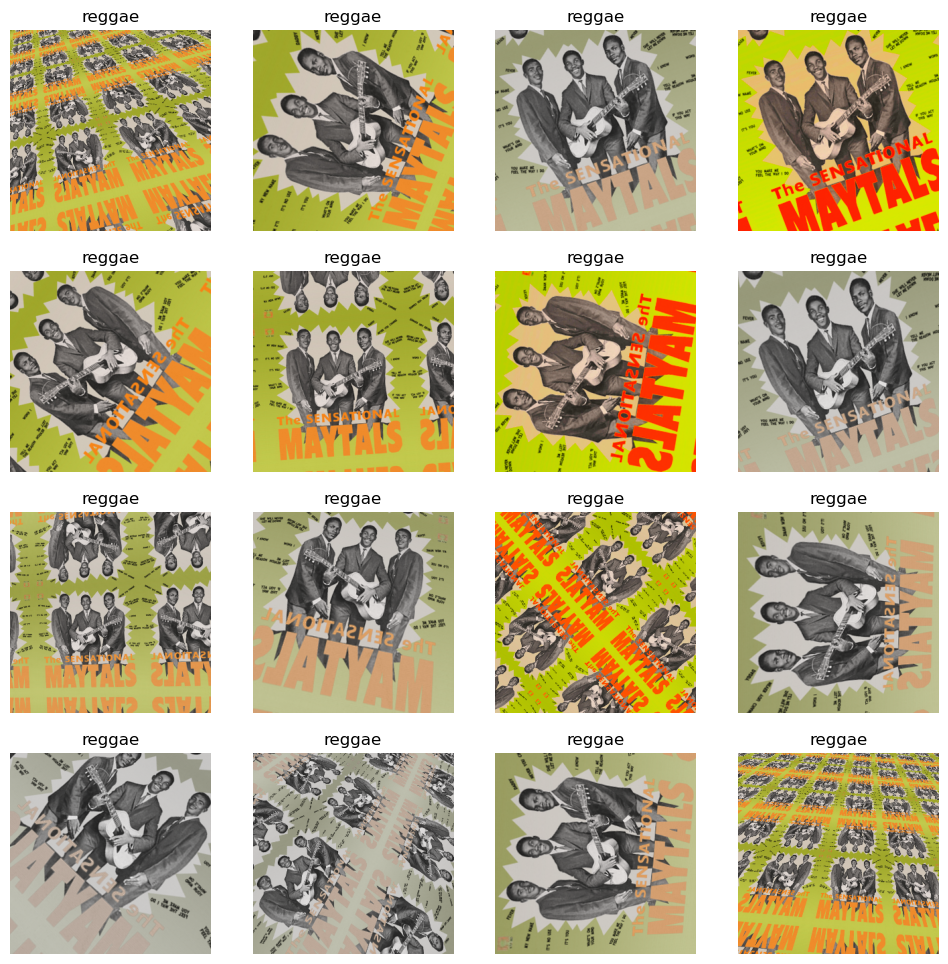

In [383]:
dls.train.show_batch(unique=True, max_n=16)

Валидационная выборка осталась неизменной, проверим это

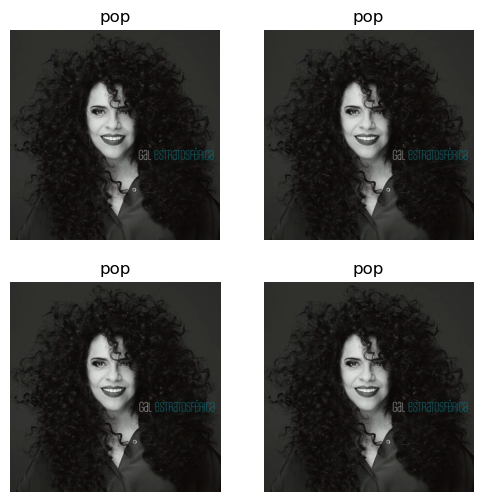

In [349]:
dls.valid.show_batch(unique=True, max_n=4)

### Подготовим нейронную сеть к обучению

Определим метрики, параметры ранней остановки и уменьшения learning rate

In [384]:
learn = vision_learner(dls, resnet50, 
                       metrics=[accuracy, F1Score(average='weighted')],
                 
                      cbs = [EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2), 
                           #  SaveModelCallback(), 
                             ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2)],
                   #   cbs= EarlyStoppingCallback(monitor='accuracy_multi', min_delta=0.1, patience=2)
                      ).to_fp16()

In [377]:
#load_learner(Path('C:/Python/Test/Model/export.pkl'))

Найдем оптимальнуый шаг итерации

SuggestedLRs(valley=0.0002754228771664202)

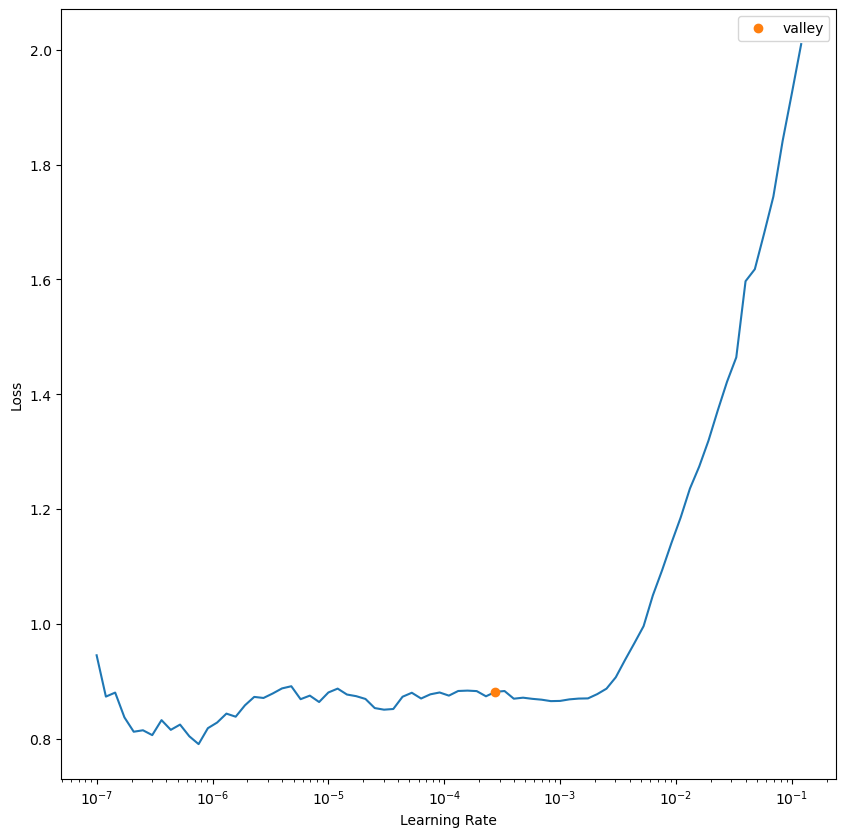

In [456]:
learn.lr_find()

### Обучим нейронную сеть

#### Запустим fine_tune модели на 10 эпохах

In [385]:
learn.fine_tune(10)

Epoch 4: reducing lr to 8.128701150237209e-05
No improvement since epoch 2: early stopping


Мы видим, что обучение прекратилось после 5 эпохи, так как не было значимого уменьшения функции потерь

In [463]:
#learn.recorder.values
#learn.recorder.plot_loss()

In [389]:
learn.summary()

Sequential (Input shape: 40 x 3 x 300 x 300)
Layer (type)         Output Shape         Param #    Trainable 
                     40 x 64 x 150 x 150 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     40 x 64 x 75 x 75   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     40 x 256 x 75 x 75  
Conv2d                                    16384      True      
BatchNorm2d                        

#### Изучим результаты

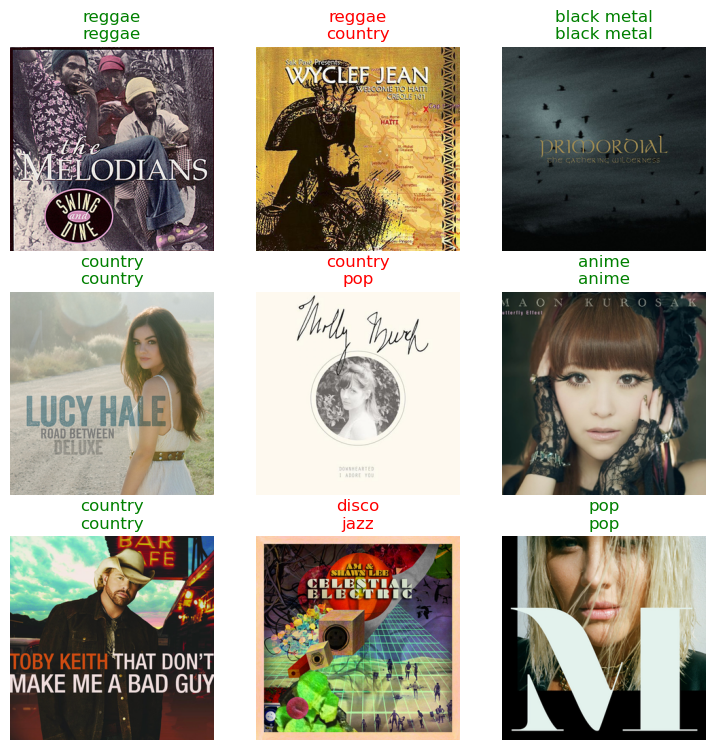

In [390]:
learn.show_results()

Anime, black metal и pop определяются достаточно хорошо, есть проблемы с определением таких жанров как reaggae, country, jazz и диско. Для более детального аналиа результатов выведем пары жанров с самыми частыми ошибками классфикации.

In [465]:
interp1 = ClassificationInterpretation.from_learner(learn)
interp1.most_confused(min_val=10)

[('pop', 'country', 46),
 ('edm', 'pop', 35),
 ('country', 'jazz', 20),
 ('country', 'pop', 20),
 ('anime', 'pop', 19),
 ('disco', 'country', 18),
 ('disco', 'pop', 17),
 ('country', 'reggae', 15),
 ('reggae', 'country', 14),
 ('anime', 'country', 13),
 ('jazz', 'classical', 13),
 ('pop', 'edm', 13),
 ('jazz', 'country', 12),
 ('pop', 'anime', 12),
 ('classical', 'country', 11),
 ('country', 'black metal', 10),
 ('disco', 'reggae', 10),
 ('reggae', 'jazz', 10)]

Хуже всего различаются следующие сочетания жанров: 

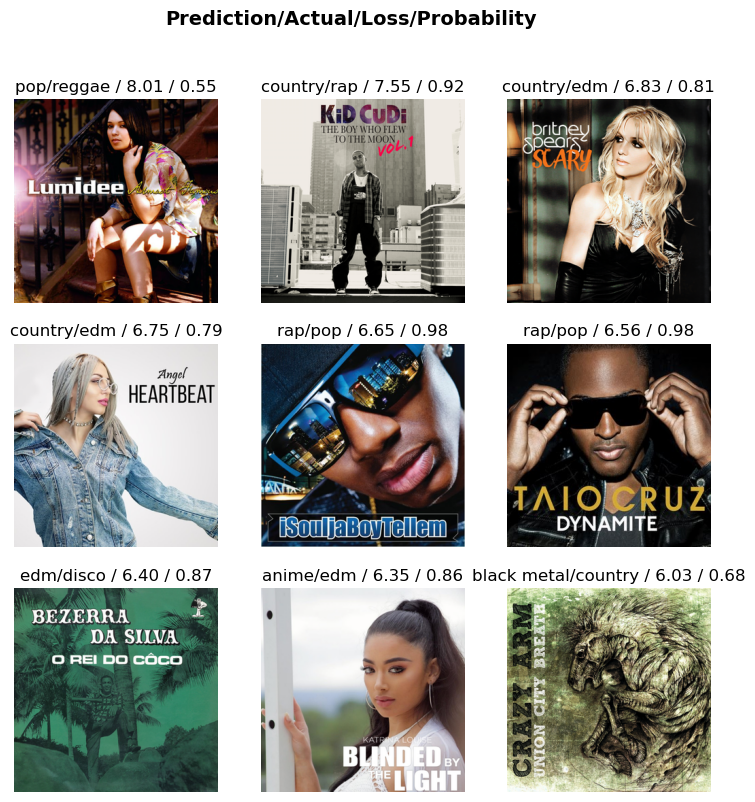

In [392]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

Изучим матрицу ошибок

In [395]:
con_matrix = ClassificationInterpretation.from_learner(learn)

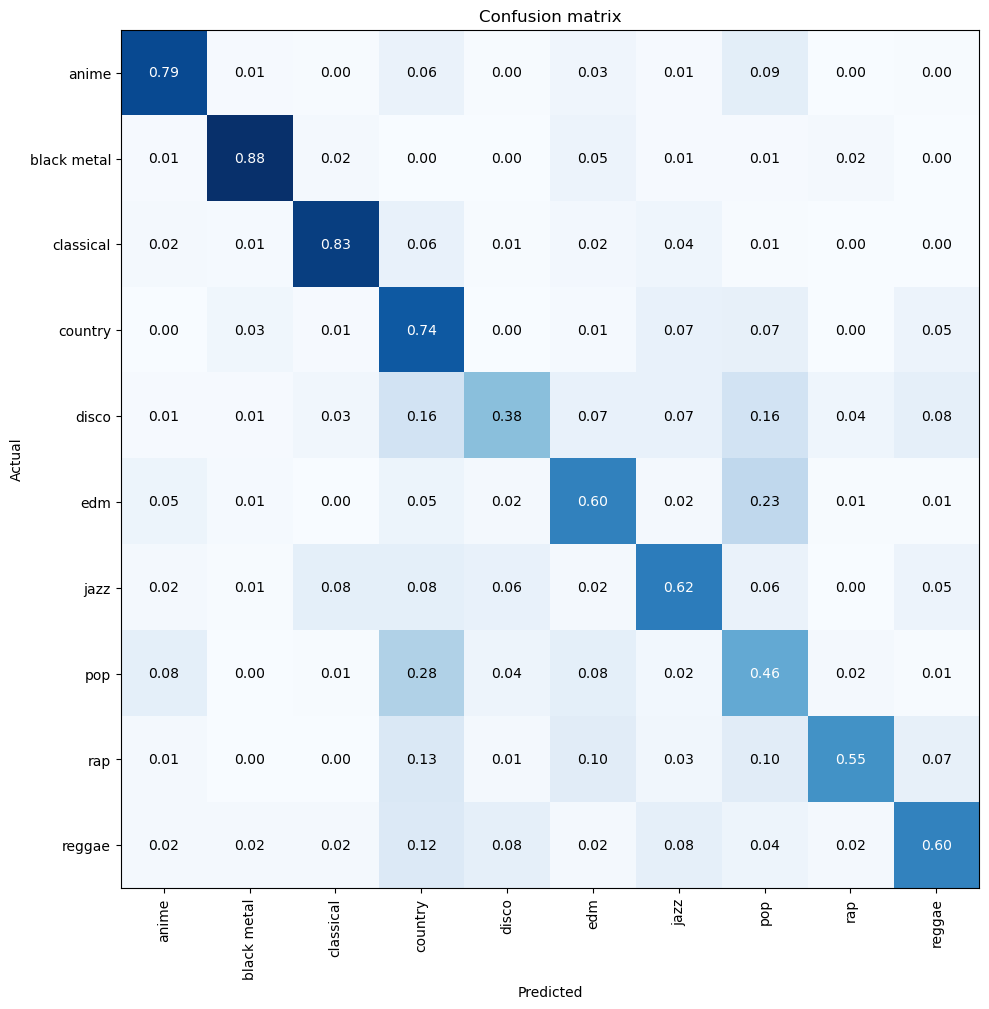

In [396]:
con_matrix.plot_confusion_matrix(normalize='pred')

Лучше всего попределяются жанры: **black metal, classical, anime, country**. 

Хуже всего определяются жанры: **disco, pop, rap**.

In [473]:
preds, targets = learn.get_preds()

In [402]:
pred_labels = preds
#pred_labels = (pred_labels>0.5)
pred_labels = preds.argmax(axis=1)
true_labels = targets

In [403]:
report = classification_report(true_labels, pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       232
           1       0.82      0.88      0.85       101
           2       0.85      0.83      0.84       172
           3       0.63      0.74      0.68       292
           4       0.54      0.38      0.44       104
           5       0.63      0.60      0.62       149
           6       0.64      0.62      0.63       158
           7       0.39      0.46      0.42       163
           8       0.75      0.55      0.63        71
           9       0.65      0.60      0.62       118

    accuracy                           0.67      1560
   macro avg       0.67      0.65      0.66      1560
weighted avg       0.68      0.67      0.67      1560



#### Промежуточные выводы:

Применение аугментации с изменением цветовой схем не дало ожидаемого результата, так как, судя по всему, цветовая гамма имеет большое значение в жанровой классификации. Нами было также проверено обучение на черно-белых обложках, которое дало очень низкий результат по метрикам качества. Запустим обучение без изменения цветовой схемы и сравним результаты.

#### Запустис fine_tune модели без аугментации

In [418]:
dls2=ImageDataLoaders.from_df(df, 
                             path='/', 
                             valid_pct=0.2,
                          #   cbs='mixup',
                          #   label_delim=' ', 
                             num_workers=2, 
                            # seed=654321,
                          #   workers = min(8, num_cpus()),
                            pin_memory=False,
                             device=torch.device('cpu'),
                           #  batch_size=2,
                             bs=40,
                            item_tfms=[Resize((224))], 
                           #  batch_tfms=aug_transforms(size=224, min_scale=0.3, p_lighting=0.75),
                            )

Проверим результат для тренирововчной выборки

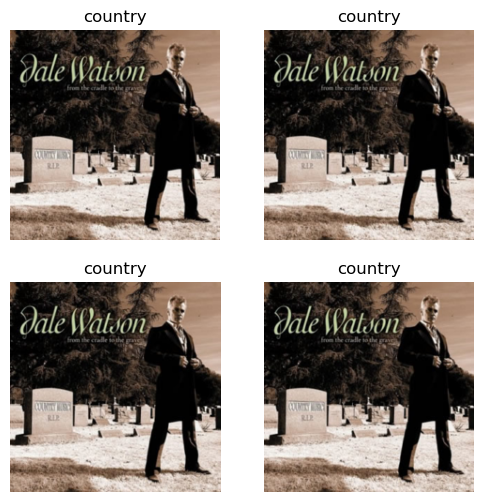

In [466]:
dls2.train.show_batch(unique=True, max_n=4)

In [420]:
learn2 = vision_learner(dls2, resnet50, 
                       metrics=[accuracy, F1Score(average='weighted')],
                      cbs = [EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2), 
                             ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2)],
                      ).to_fp16()

Определим оптимальную learning rate

SuggestedLRs(valley=0.001737800776027143)

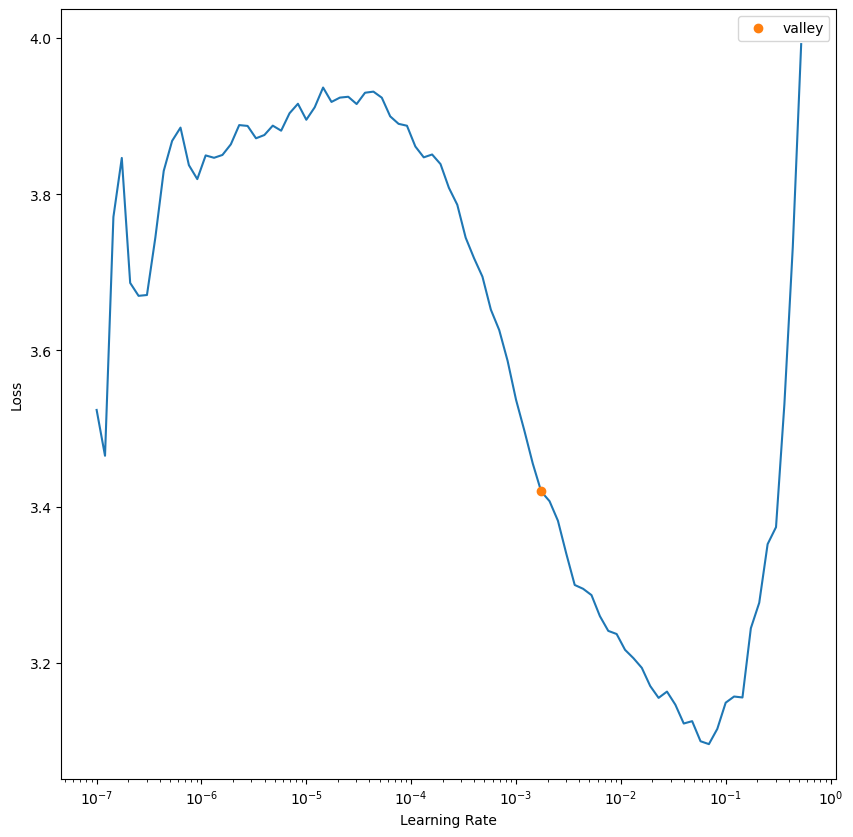

In [423]:
learn2.lr_find()

Запустим fine_tune на 10 этпохах

In [424]:
learn2.fine_tune(10, 0.0017)

Epoch 2: reducing lr to 8.499923389982075e-05
No improvement since epoch 0: early stopping


Мы видим, что обучение прекратилось после 3 эпохи, так как не было значимого уменьшения функции потерь

In [451]:
learn2.recorder.values

[(#4) [1.1727149486541748,1.1112816333770752,0.6352564096450806,0.6305248604351094],
 (#4) [0.858620285987854,1.1081569194793701,0.6538461446762085,0.6491008238751526],
 (#4) [0.5545495748519897,1.1338152885437012,0.6711538434028625,0.6687237996573958]]

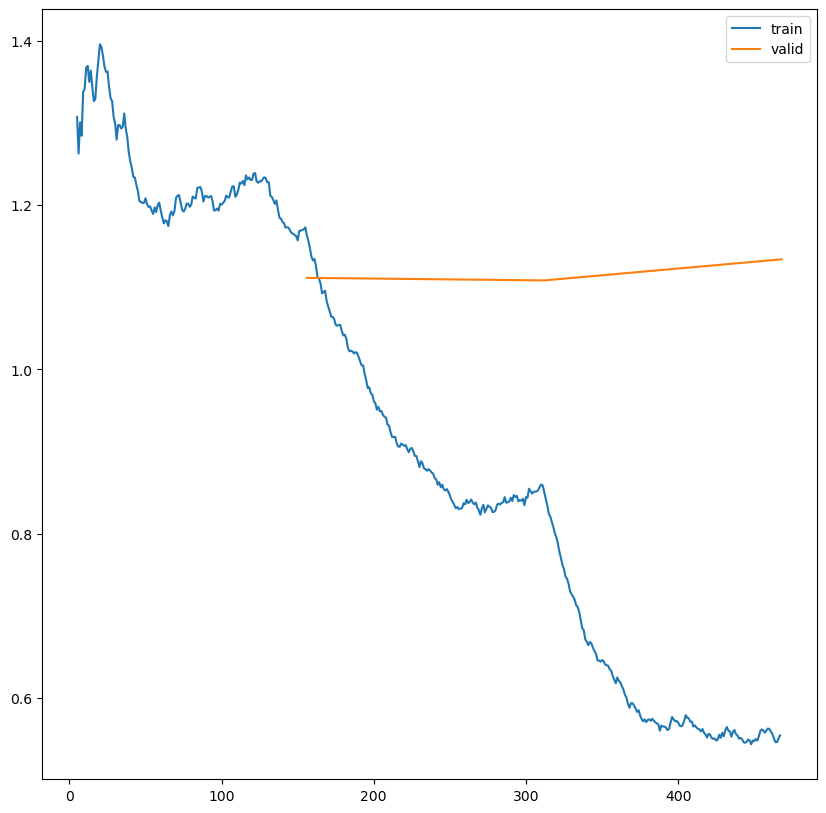

In [454]:
learn2.recorder.plot_loss()

#### Изучим результаты

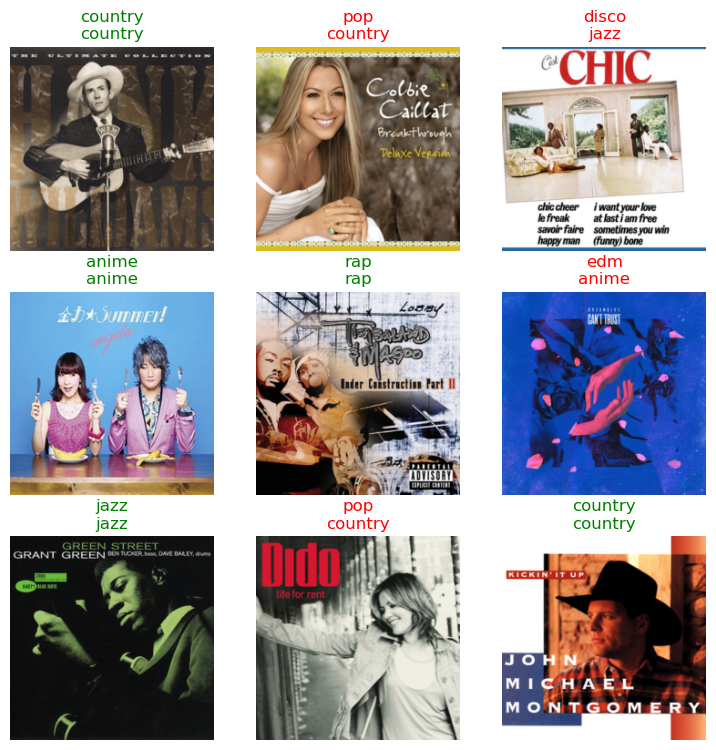

In [468]:
learn2.show_results()

In [469]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.most_confused(min_val=10)

[('jazz', 'country', 23),
 ('country', 'jazz', 21),
 ('country', 'pop', 19),
 ('edm', 'anime', 19),
 ('pop', 'country', 18),
 ('edm', 'pop', 17),
 ('jazz', 'classical', 14),
 ('anime', 'pop', 13),
 ('classical', 'jazz', 13),
 ('edm', 'black metal', 13),
 ('jazz', 'disco', 12),
 ('jazz', 'pop', 12),
 ('jazz', 'reggae', 12),
 ('anime', 'country', 11),
 ('disco', 'jazz', 11),
 ('pop', 'anime', 11),
 ('pop', 'edm', 11),
 ('pop', 'jazz', 11)]

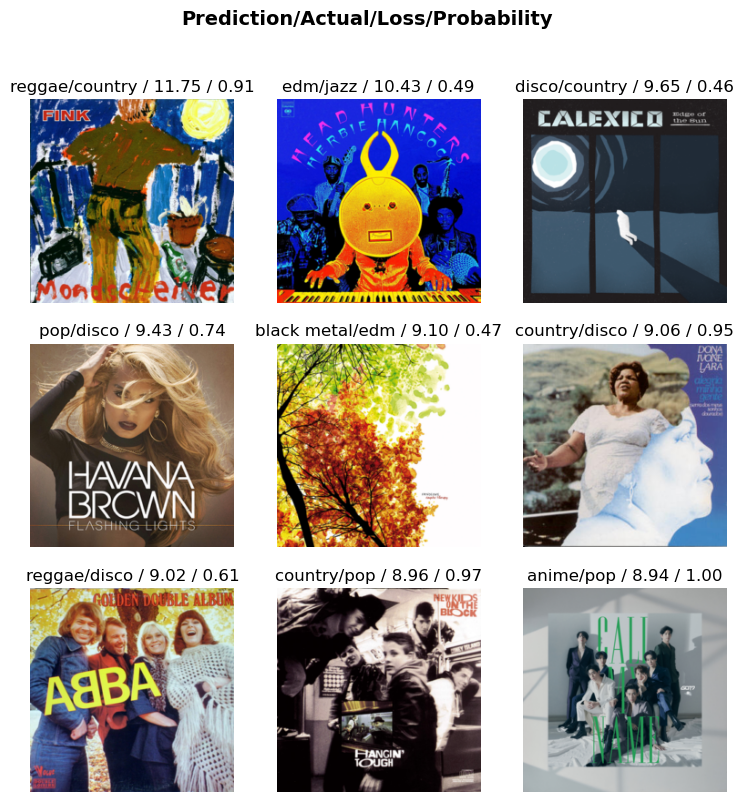

In [470]:
interp2 = Interpretation.from_learner(learn2)
interp2.plot_top_losses(9)

Ситуация изменилась несильно, также плохо определяются жанры jazz, disco, pop.

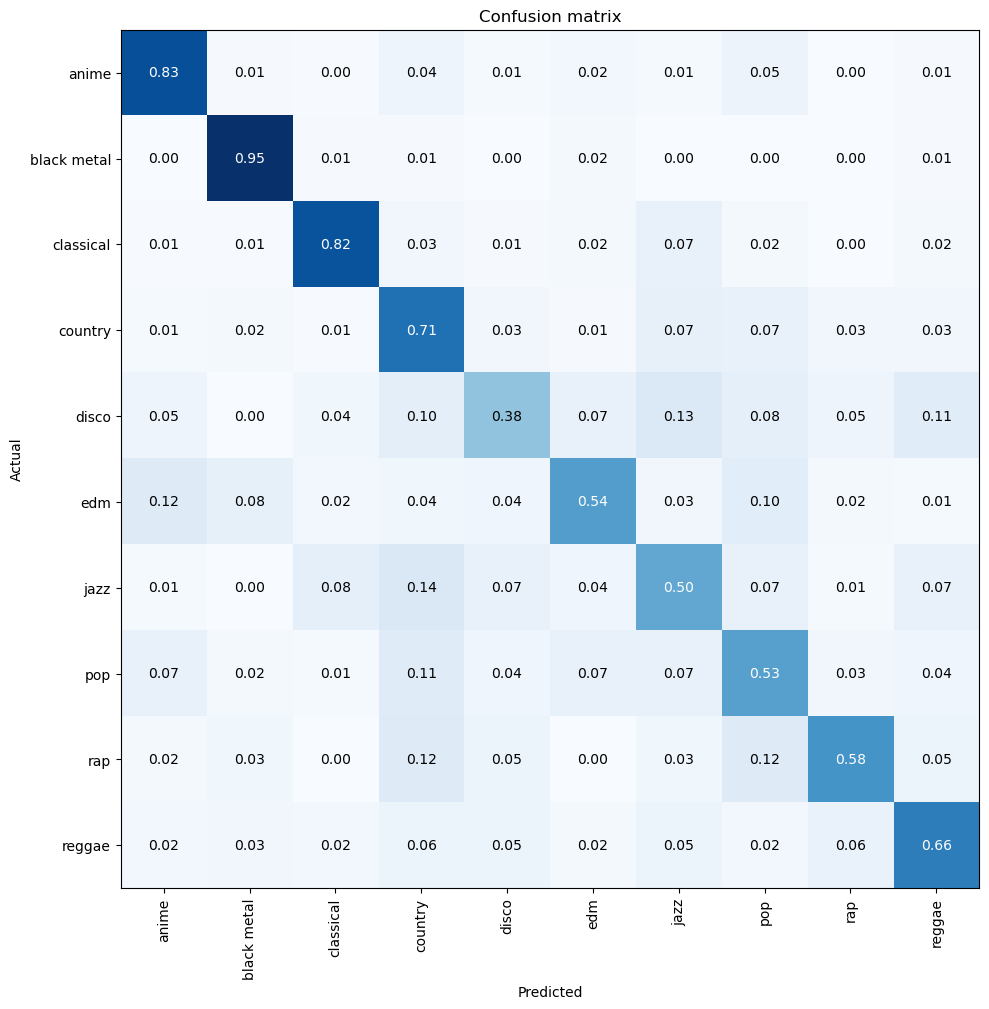

In [474]:
con_matrix2 = ClassificationInterpretation.from_learner(learn2)
con_matrix2.plot_confusion_matrix(normalize='pred')

In [475]:
preds2, targets2 = learn2.get_preds()

In [476]:
pred_labels2 = preds2
#pred_labels = (pred_labels>0.5)
pred_labels2 = preds2.argmax(axis=1)
true_labels2 = targets2

In [477]:
report2 = classification_report(true_labels2, pred_labels2)
print(report2)

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       248
           1       0.74      0.95      0.83        92
           2       0.83      0.82      0.82       181
           3       0.70      0.71      0.70       280
           4       0.40      0.38      0.39        84
           5       0.68      0.54      0.60       165
           6       0.54      0.50      0.52       168
           7       0.51      0.53      0.52       158
           8       0.53      0.58      0.56        60
           9       0.64      0.66      0.65       124

    accuracy                           0.67      1560
   macro avg       0.64      0.65      0.64      1560
weighted avg       0.67      0.67      0.67      1560



#### Промежуточные выводы:

Такие жанры как black metal и anime стали определяться лучше, что логично, так как для них характерна определенная цветовая схема, отличная от других жанров. Остальные жанры, кроме rap и reggae, стали определяться немного хуже.

Результаты работы модели с аугментацией и без - сопроставимы

### Проверим работу модели на своем изображении

Напишем функцию для предсказания жанра

In [509]:
def cover(url):
    image_url = url
    response = requests.get(image_url)
    img = PILImage.create((response.content))
    pred1, _1, _1 = learn.predict(img)
    pred2, _, _ = learn2.predict(img)
    return print(f"Жанр1: {pred1}"), print(f"Жанр2: {pred2}"), img.show();    

In [510]:
list_of_images=['https://imagine-club.com/sites/default/files/photos/delo_vkusa_leontev_valeriy_1_lp_melodiya_sssr_1_0.jpg',
'https://irenmorgulis.com/wp-content/uploads/2023/12/fonstola.ru_201838.jpg',
               'https://images.squarespace-cdn.com/content/v1/565c1ab5e4b05079e4bfa169/1663047676862-UWWJZQD7HBSQKBYXVPKX/Madonna+MDNA+Album+Cover.jpg']
                

    

Жанр1: disco
Жанр2: disco


(None, None, <Axes: >)

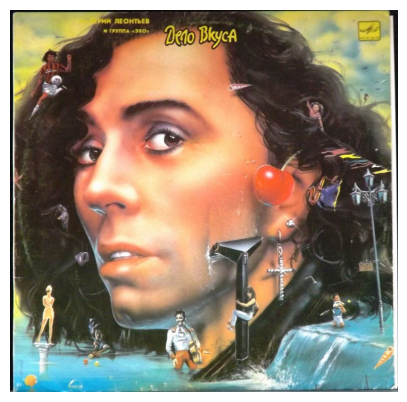

In [511]:
for i in list_of_images:
    cover(i)

Результат работы модели для выбранных изображений считаем приемлемым

#### Промежуточные выводы

Для более точного прогноза считаем необходимым также излечь текстовые данные и обрабоать их. Предлагаем сделать это следующим образом:
- извлечь текст из изображения
- посчитать эмбеддинги
- воспользоваться моелью CatBoostCls и ее встроенными методами обработки текста и эмбеддингов
- воспользоваться Fastai text learner
- оценить предсказания и сравнить результаты

## Извлечем текст из изображения


In [461]:
#df.head()

#### Опробуем pytesseract на одном изображении

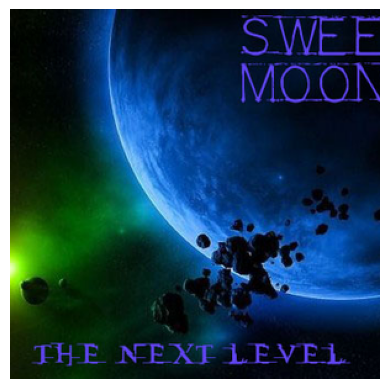

In [8]:
image = Image.open('/home/jovyan/work/Master_Music/Data/images/disco/2e8b9d87-f45a-4c25-95dc-890381731397.png')
image = image.resize((300,300))
array = np.array(image)
plt.imshow(array)
plt.axis('off')
plt.rcParams["figure.figsize"] = (3,3)
plt.show()

Применим кастомные настройки: языки - русский и английский, сегментацию - Assume a single uniform block of text, определим разрешенные символы в whitelist, затем очистим текст от лишних символов

In [9]:
string = pytesseract.image_to_string(image, lang='eng+rus', config='--psm 6 --oem 1 tessedit_char_whitelist=ABCDEFG0123456789')
string

'Rie WEE\nPetan\nTHE a EVEL\n\x0c'

#### Опробуем easyocr на одном изображении

In [28]:
reader = easyocr.Reader(['en'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


In [29]:
reader2 = easyocr.Reader(['ja'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


In [30]:
#reader = easyocr.Reader(['en'])
reader.readtext('/home/jovyan/work/Master_Music/Data/images/disco/2e8b9d87-f45a-4c25-95dc-890381731397.png', detail=0, paragraph=True)

['SWEE MOON', 'THE NEXT LEVEL']

Результат работы easyocr более правдоподобный, применим его для всего текста, запишем в таблицу новый столбец с текстом, приведем весь текст к нижнему регистру.

In [31]:
text1=[]
for i in range(len(df)):
    image1 = df.iloc[i]['path']
    image = Image.open(df.iloc[i]['path'])
   # assert not isinstance(image1,type(None))
    try:
        text_list = reader.readtext(image1, detail=0)
        text1.append(text_list)
    except:
        string = pytesseract.image_to_string(image, lang='eng+rus', config='--psm 6 --oem 1 tessedit_char_whitelist=ABCDEFG0123456789')
        text1.append(string)
        

In [33]:
len(text1)

7800

In [34]:
df['text1'] = text1

In [43]:
#df.head(5)

Приведем к нижнему регистру и очистим текст

In [36]:
#df.head()

In [37]:
def clear_text(text):
    lemm_engl = re.sub(r'[^a-zA-Z^а-яА-Я^0-9^\n]', ' ', text)
    lemm_no_space = lemm_engl.split()
    lemm = " ".join(lemm_no_space)
    return lemm

In [38]:
tqdm.pandas(desc="progress")

In [39]:
df['text2'] = df['text1'].astype(str).progress_apply(clear_text) 

progress: 100%|██████████| 7800/7800 [00:00<00:00, 45245.75it/s]


In [40]:
#df.head(5)

In [41]:
df['text3'] = df['text2'].str.lower()

In [46]:
df.head(10)

path  \
0  /home/jovyan/work/Master_Music/Data/images/disco/358c179f-2158-449f-838f-3c7ec136d8e2.png   
1  /home/jovyan/work/Master_Music/Data/images/disco/556fbf52-4ecb-4b2d-b0e8-1332459ede3e.png   
2  /home/jovyan/work/Master_Music/Data/images/disco/2e8b9d87-f45a-4c25-95dc-890381731397.png   
3  /home/jovyan/work/Master_Music/Data/images/disco/886dd611-cb45-4bf0-87f0-a904105b2ff6.png   
4  /home/jovyan/work/Master_Music/Data/images/disco/503073f1-3278-4132-b528-6c6dc4577696.png   
5  /home/jovyan/work/Master_Music/Data/images/disco/bb004e58-03a3-4c61-9687-af6163d8b49f.png   
6  /home/jovyan/work/Master_Music/Data/images/disco/c4773244-233c-4a89-b719-76bea8d8e7c7.png   
7  /home/jovyan/work/Master_Music/Data/images/disco/155f11ef-a311-42ab-91de-844ddea2d767.png   
8  /home/jovyan/work/Master_Music/Data/images/disco/f6804b79-a45a-4f6d-a3e1-aa7f2c4626c5.png   
9  /home/jovyan/work/Master_Music/Data/images/disco/91937f3d-f163-41dc-8123-b2936ee33e13.png   

   label                                         text1  \
0  disco                             [Reva, SToTT, DT]   
1  disco               [MoveBREAKERS, 486?, YQU, HERE]   
2  disco                 [SWEE, MOON, THE, NEXT LEVEL]   
3  disco            [THE RITCHIE FAMILY, LIL IS MUSIC]   
4  disco     [@rmn Of Lovers, MASSIVE LUXURY OVERDOSE]   
5  disco  [DONNA SUMMEI, 'HAMA, On tho Radta "VOLUmS]]   
6  disco                  [#VEA9TLEGMIAE, BelynThomas]   
7  disco                                         [Gal]   
8  disco                            [Mlwsz hofy, Iuxs]   
9  disco                   [DILHIDS, born to be cheap]   

                                   text2  \
0                          Reva SToTT DT   
1              MoveBREAKERS 486 YQU HERE   
2               SWEE MOON THE NEXT LEVEL   
3        THE RITCHIE FAMILY LIL IS MUSIC   
4  rmn Of Lovers MASSIVE LUXURY OVERDOSE   
5  DONNA SUMMEI HAMA On tho Radta VOLUmS   
6               VEA9TLEGMIAE BelynThomas   
7                                    Gal   
8                        Mlwsz hofy Iuxs   
9               DILHIDS born to be cheap   

                                   text3  
0                          reva stott dt  
1              movebreakers 486 yqu here  
2               swee moon the next level  
3        the ritchie family lil is music  
4  rmn of lovers massive luxury overdose  
5  donna summei hama on tho radta volums  
6               vea9tlegmiae belynthomas  
7                                    gal  
8                        mlwsz hofy iuxs  
9               dilhids born to be cheap

### Вычислим эмбеддинги для текстового столбца 

Выберем языковую модель

In [24]:
model_st = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [47]:
def get_embeddinngs(text):
    return model_st.encode(text, convert_to_numpy=True)

In [48]:
df['text_emb3'] = df['text3'].progress_apply(get_embeddinngs)

progress: 100%|██████████| 7800/7800 [01:59<00:00, 65.04it/s]


In [49]:
df.head(2)

path  \
0  /home/jovyan/work/Master_Music/Data/images/disco/358c179f-2158-449f-838f-3c7ec136d8e2.png   
1  /home/jovyan/work/Master_Music/Data/images/disco/556fbf52-4ecb-4b2d-b0e8-1332459ede3e.png   

   label                            text1                      text2  \
0  disco                [Reva, SToTT, DT]              Reva SToTT DT   
1  disco  [MoveBREAKERS, 486?, YQU, HERE]  MoveBREAKERS 486 YQU HERE   

                       text3  \
0              reva stott dt   
1  movebreakers 486 yqu here   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text_emb3  
0  [-0.058536295, 0.06616765, -0.038595714, -0.002639841, -0.10769389, 0.02803709, -0.00062130106, 0.05593462, 0.04772919, 0.00032522134, 0.019494299, -0.030125866, -0.03420695, -0.05723925, -0.039319698, 0.03812964, 0.013433691, 0.07963745, 0.062064566, -0.003053845, -0.09440714, 0.10675485, -0.045401122, 0.05559912, -0.025565038, 0.035920974, 0.026682543, -0.0063698995, -0.06046311, -0.09474028, -0.008078475, -0.016549775, -0.0039794575, 0.01082133, -0.044289134, 0.086697645, -0.058060378, -0.028001986, 0.0590181, 0.09379876, -0.042400006, -0.048531864, -0.00052898127, -0.05795107, 0.022124...  
1  [-0.04081943, -0.04881953, -0.031402893, -0.07123863, 0.03294788, 0.04545336, 0.046731357, 0.0045902156, -0.016530553, -0.010458884, 0.017294768, 0.05002756, -0.05271905, -0.041014522, 0.022789717, 0.04916922, -0.056430206, -0.022156574, -0.037381344, 0.022316711, -0.030214502, -0.020942839, -0.083917655, -0.0022353895, 0.090594225, 0.103385836, -0.062929265, 0.073382296, 0.02618821, -0.07664114, -0.0057474785, 0.08770438, 0.021493196, 0.024266332, 0.06439667, 0.02830235, 0.015956447, -0.037102953, -0.0020389478, -0.01707233, -0.017239174, 0.01762481, 0.0050215703, 0.032829907, -0.02543001...

Удалим лишние столбцы

In [52]:
df3=df.drop(columns=['text1'], axis=1)

In [53]:
df3.head(3)

path  \
0  /home/jovyan/work/Master_Music/Data/images/disco/358c179f-2158-449f-838f-3c7ec136d8e2.png   
1  /home/jovyan/work/Master_Music/Data/images/disco/556fbf52-4ecb-4b2d-b0e8-1332459ede3e.png   
2  /home/jovyan/work/Master_Music/Data/images/disco/2e8b9d87-f45a-4c25-95dc-890381731397.png   

   label                      text2                      text3  \
0  disco              Reva SToTT DT              reva stott dt   
1  disco  MoveBREAKERS 486 YQU HERE  movebreakers 486 yqu here   
2  disco   SWEE MOON THE NEXT LEVEL   swee moon the next level   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text_emb3  
0  [-0.058536295, 0.06616765, -0.038595714, -0.002639841, -0.10769389, 0.02803709, -0.00062130106, 0.05593462, 0.04772919, 0.00032522134, 0.019494299, -0.030125866, -0.03420695, -0.05723925, -0.039319698, 0.03812964, 0.013433691, 0.07963745, 0.062064566, -0.003053845, -0.09440714, 0.10675485, -0.045401122, 0.05559912, -0.025565038, 0.035920974, 0.026682543, -0.0063698995, -0.06046311, -0.09474028, -0.008078475, -0.016549775, -0.0039794575, 0.01082133, -0.044289134, 0.086697645, -0.058060378, -0.028001986, 0.0590181, 0.09379876, -0.042400006, -0.048531864, -0.00052898127, -0.05795107, 0.022124...  
1  [-0.04081943, -0.04881953, -0.031402893, -0.07123863, 0.03294788, 0.04545336, 0.046731357, 0.0045902156, -0.016530553, -0.010458884, 0.017294768, 0.05002756, -0.05271905, -0.041014522, 0.022789717, 0.04916922, -0.056430206, -0.022156574, -0.037381344, 0.022316711, -0.030214502, -0.020942839, -0.083917655, -0.0022353895, 0.090594225, 0.103385836, -0.062929265, 0.073382296, 0.02618821, -0.07664114, -0.0057474785, 0.08770438, 0.021493196, 0.024266332, 0.06439667, 0.02830235, 0.015956447, -0.037102953, -0.0020389478, -0.01707233, -0.017239174, 0.01762481, 0.0050215703, 0.032829907, -0.02543001...  
2  [-0.04279248, -0.0641733, 0.022191573, -0.027093077, -0.039974973, -0.05320582, 0.019770198, -0.050207596, -0.012012333, -0.058468744, 0.013153194, -0.080388196, 0.036823332, -0.056813266, -0.005944439, 0.08609814, -0.011569347, 0.08937604, -0.036926106, -0.073248275, -0.0054213447, -0.022427954, 0.03698217, -0.013975495, -0.0158053, 0.06791556, -0.015586412, 0.0043117898, 0.017210782, -0.048023637, 0.046121273, 0.12546664, -0.10693857, 0.006057091, -0.045326214, 0.027629366, 0.014953235, -0.08283585, -0.007303322, 0.0119512845, -0.090070024, -0.113200694, -0.051465854, 0.011928486, 0.0010...

#### Выделим текстовые признаки и столбцы с эмбеддингами

In [74]:
text_features = ['text2']
embedding_features=['text_emb3']

#### Определим целевой признак и разобъем данные на выборки

In [75]:
x_data = df3.drop(columns=['label','path', 'text3'],axis=1)
y_data = df3['label']

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.30,random_state=654321, stratify=y_data)

In [76]:
eval_set = (x_test, y_test)

#### Обучим модель CatBoostClassifier c подбором параметров RandomSearch

In [77]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

Подбор параметров пришлось сократить до минимума в связи с техническими ограничениями 

In [78]:
modelRS = CatBoostClassifier(loss_function='MultiClass', random_state=654321, verbose=False, used_ram_limit='22GB', use_best_model= True,  early_stopping_rounds=100, text_features=text_features, embedding_features=embedding_features)
 
# Define the parameter distributions for Random Search
param_dist = {
    'iterations': [800],
    'learning_rate': [0.05],
  #   'depth': range(1, 16, 1),
  #  'l2_leaf_reg': range(3, 15, 1),
 #   'eval_metric' : ['TotalF1'],
   # 'leaf_estimation_iterations': range(1,15, 1),
#    'bagging_temperature': [0, 0.5, 1],
#    'one_hot_max_size': [2],
 #  'leaf_estimation_method': ['Gradient'],
  #  'bootstrap_type' : ['Bayesian'],
      'auto_class_weights' : ['Balanced'],
   # 'class_weights': [{1: 1, 2: 3, 3: 1, 4: 5}, {1: 0.44444444, 2: 3.13043478, 3: 0.87804878, 4: 3.42857143}]
}
 
# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(modelRS, param_distributions=param_dist, n_iter=5, cv=5, scoring='f1_weighted', n_jobs=-1, random_state=654321, error_score='raise')
random_search.fit(x_train, y_train, eval_set=eval_set, text_features=text_features, embedding_features=embedding_features)
 
# Print the best hyperparameters for Random Search
print("Random Search - Best Hyperparameters:", random_search.best_params_)

Random Search - Best Hyperparameters: {'learning_rate': 0.05, 'iterations': 800, 'auto_class_weights': 'Balanced'}


In [79]:
best_RSt = random_search.best_estimator_
best_pred_yRSt = random_search.predict(x_train)

print(classification_report(y_train, best_pred_yRSt))

              precision    recall  f1-score   support

       anime       0.52      0.66      0.58       832
 black metal       0.28      0.43      0.34       315
   classical       0.92      0.86      0.89       668
     country       0.78      0.57      0.66      1040
       disco       0.43      0.39      0.41       328
         edm       0.67      0.42      0.51       503
        jazz       0.62      0.64      0.63       575
         pop       0.48      0.39      0.43       562
         rap       0.29      0.61      0.39       230
      reggae       0.53      0.49      0.51       407

    accuracy                           0.57      5460
   macro avg       0.55      0.55      0.53      5460
weighted avg       0.61      0.57      0.58      5460



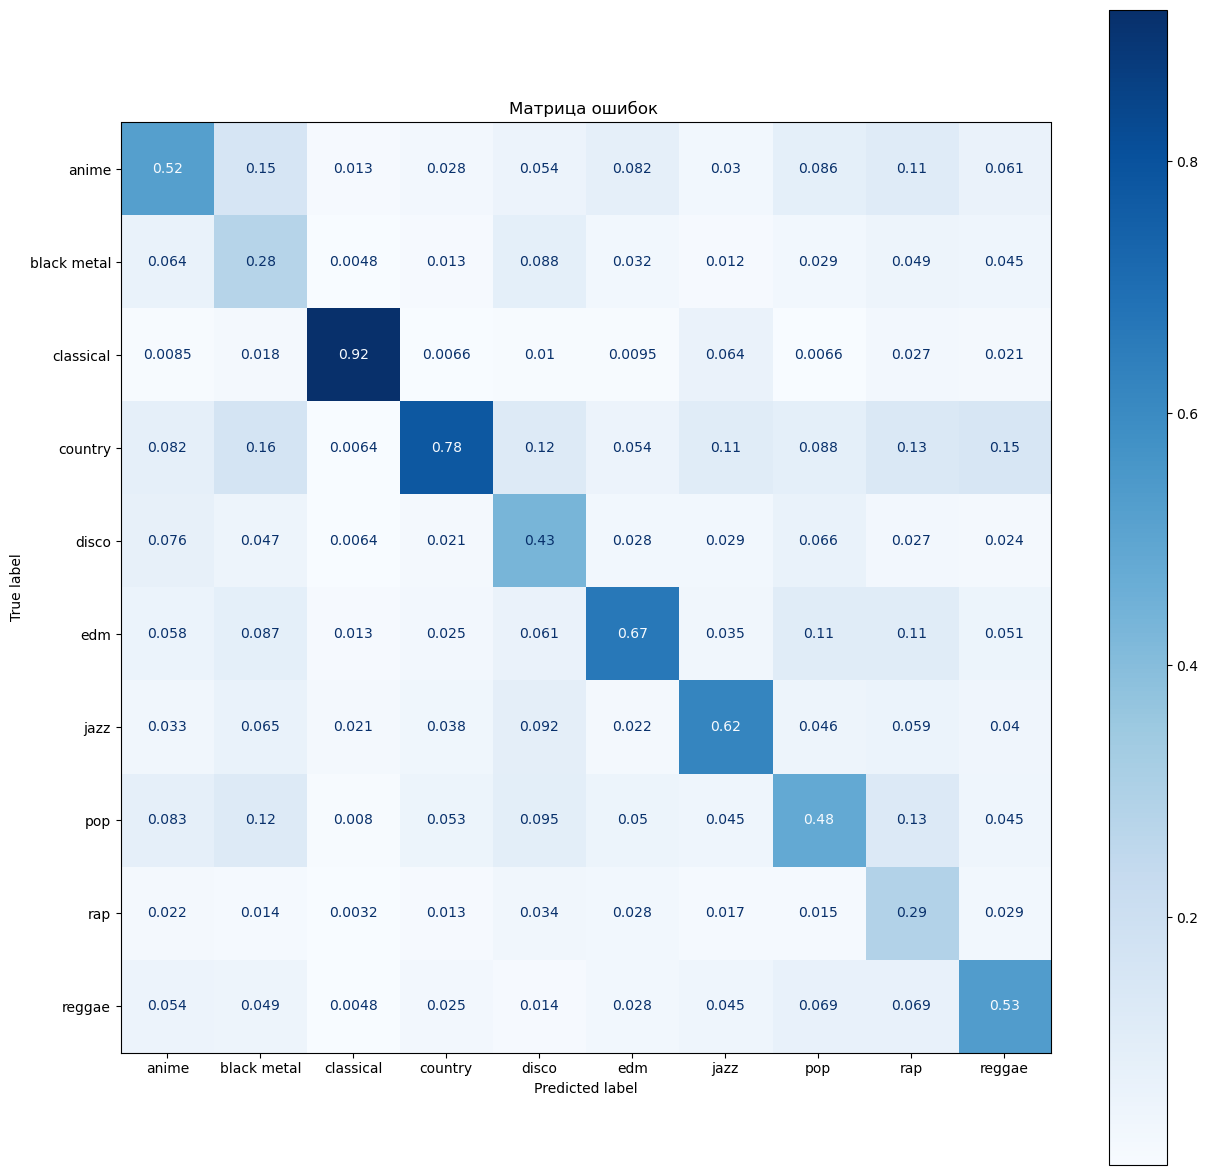

In [83]:
disp3 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, best_pred_yRSt, normalize='pred', labels=random_search.classes_),
                               display_labels=random_search.classes_)
disp3.plot(cmap='Blues')
disp3.ax_.set_title("Матрица ошибок ")
plt.rcParams["figure.figsize"] = (15, 15)
plt.show()
plt.close()

Рассмотрим распределние классов, чтобы лучше представлять, какие классы определяются хуже из-за малочисленности

In [ ]:
balance = df['label'].value_counts()

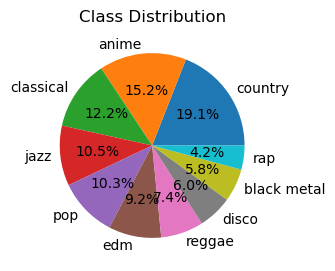

In [463]:
plt.pie(balance.values, labels=balance.index.values, autopct='%1.1f%%') 
  
plt.title("Class Distribution") 
  

plt.show()
plt.rcParams['figure.figsize'] = [3, 3]
plt.show()

#### Промежуточные выводы

Мы видим, что путем извлечения текста, можно улучшить выявление таких жанров как classical, country, edm и jazz даже без увеличения выбокри

### Используем UMAP для визуализации и кластеризации данных

Подготовим данные для визуализации

In [118]:
df4 = df3.reset_index(drop=True)

In [120]:
x = df4['text_emb3']
y = df4['label']

In [111]:
len(x)

7800

In [122]:
X_umap=[]
for i in range(len(x)):
    out = np.array(x[i], dtype=object)
    X_umap.append(out)
    

Закодируем таргет

In [128]:
labelencoder = LabelEncoder()
data_new = labelencoder.fit_transform(y.values)
labelencoder.classes_

array(['anime', 'black metal', 'classical', 'country', 'disco', 'edm',
       'jazz', 'pop', 'rap', 'reggae'], dtype=object)

Масштабируем признаки и построим облако точек

In [151]:
# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X_umap.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP().fit(X_umap, y_encoded)


UsageError: Line magic function `%%time` not found.


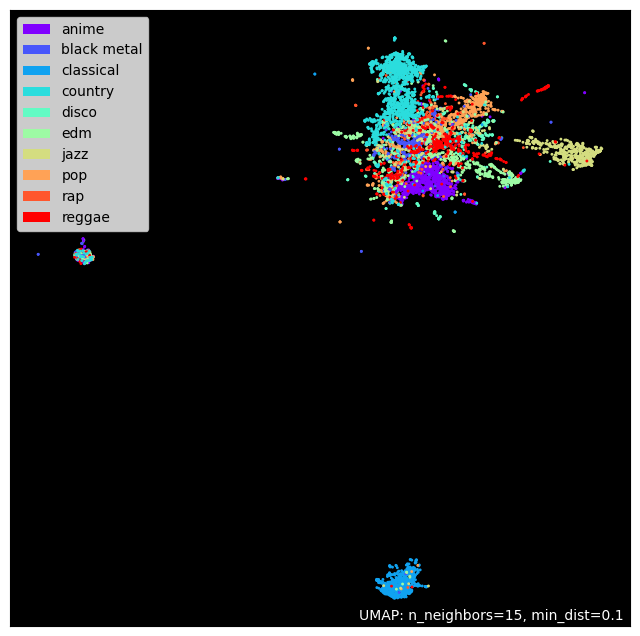

In [157]:
umap.plot.points(manifold, labels=y, theme="fire")

На приведенном выше изображении отчетлтво видно, что текстовые признаки хорошо детерминируют такие жанры как: jazz, classical, country. Также неплохо кластеризуется anime

### Обучим нейронную сеть для текстовых признаков, используя FastAI

In [169]:
df4= df3.drop(columns= ['path', 'text2', 'text_emb3'], axis=1)
df4.head(2)

label                      text3
0  disco              reva stott dt
1  disco  movebreakers 486 yqu here

Создадим загрузчик данных из таблицы

In [175]:
dls_text=TextDataLoaders.from_df(df4, 
                           #  path='/', 
                             valid_pct=0.2,
                                 text_col='text3',
                                 label_col='label',
                          #   cbs='mixup',
                          #   label_delim=' ', 
                             num_workers=2, 
                            # seed=654321,
                          #   workers = min(8, num_cpus()),
                            pin_memory=False,
                             device=torch.device('cpu'),
                           #  batch_size=2,
                             bs=40
                            )

Изучим результаты для тренировочной выборки

In [462]:
dls_text.train.show_batch(max_n=3)

Подготовим нейронную сеть к обучению

In [187]:
learn_text = text_classifier_learner(dls_text, 
                        AWD_LSTM, 
                       metrics=[accuracy, F1Score(average='weighted')],
                 
                      cbs = [EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=2), 
                           #  SaveModelCallback(), 
                             ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, patience=2)],
                   #   cbs= EarlyStoppingCallback(monitor='accuracy_multi', min_delta=0.1, patience=2)
                      ).to_fp16()

Найдем оптимальную learning rate

SuggestedLRs(valley=0.02290867641568184)

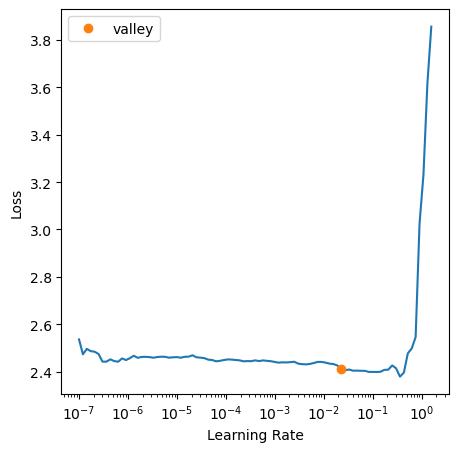

In [188]:
learn_text.lr_find()

Запустим fine_tune модели на 25 эпохах

In [189]:
learn_text.fine_tune(25, 1e-4)

Epoch 13: reducing lr to 3.4852226400223084e-06
No improvement since epoch 11: early stopping


Изучим результат

In [185]:
learn_text.show_results()

Обработка текстовых признаков с использованием нейронных сетей также дает прирост определяемости classical и jazz

Изучим, какие жанры определяются хуже всего

In [190]:
interp3 = ClassificationInterpretation.from_learner(learn_text)
interp3.most_confused(min_val=10)

[('country', 'black metal', 58),
 ('country', 'anime', 56),
 ('anime', 'black metal', 52),
 ('jazz', 'classical', 39),
 ('edm', 'black metal', 37),
 ('pop', 'anime', 37),
 ('country', 'jazz', 36),
 ('pop', 'black metal', 36),
 ('reggae', 'black metal', 34),
 ('disco', 'black metal', 29),
 ('country', 'classical', 28),
 ('edm', 'anime', 26),
 ('anime', 'pop', 25),
 ('jazz', 'country', 25),
 ('reggae', 'anime', 24),
 ('jazz', 'black metal', 23),
 ('reggae', 'country', 22),
 ('country', 'reggae', 21),
 ('edm', 'country', 20),
 ('rap', 'black metal', 20),
 ('pop', 'country', 19),
 ('black metal', 'anime', 16),
 ('jazz', 'anime', 16),
 ('anime', 'country', 15),
 ('anime', 'reggae', 15),
 ('reggae', 'pop', 15),
 ('black metal', 'pop', 14),
 ('disco', 'anime', 14),
 ('edm', 'classical', 14),
 ('anime', 'classical', 13),
 ('pop', 'reggae', 13),
 ('disco', 'pop', 12),
 ('edm', 'pop', 12),
 ('rap', 'anime', 12),
 ('edm', 'jazz', 11),
 ('disco', 'country', 10),
 ('disco', 'reggae', 10),
 ('edm', 

In [192]:
interp3 = Interpretation.from_learner(learn_text)
interp3.plot_top_losses(20)

Мы видим, что используя текстовые признаки, ухудшается распознавания anime и black metal.

In [193]:
con_matrix_t = ClassificationInterpretation.from_learner(learn_text)

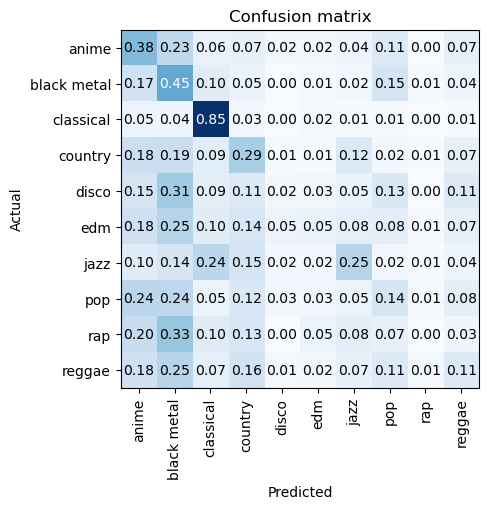

In [194]:
con_matrix_t.plot_confusion_matrix(normalize='pred')

In [195]:
preds_t, targets_t = learn_text.get_preds()

In [198]:
pred_labels_t = preds_t.argmax(axis=1)

In [200]:
report_text = classification_report(targets_t, pred_labels_t)
print(report_text)

              precision    recall  f1-score   support

           0       0.29      0.38      0.32       223
           1       0.12      0.45      0.19        94
           2       0.54      0.85      0.66       188
           3       0.41      0.29      0.34       303
           4       0.07      0.02      0.03        93
           5       0.22      0.05      0.09       146
           6       0.33      0.25      0.28       164
           7       0.19      0.14      0.16       153
           8       0.00      0.00      0.00        60
           9       0.15      0.11      0.13       136

    accuracy                           0.30      1560
   macro avg       0.23      0.25      0.22      1560
weighted avg       0.28      0.30      0.27      1560



#### Промежуточные выводы

Таким образом, использование тектовых признаков может улучшить определение ряда жанров, которые трудно определяются путем сопоставления изображений, без увеличения размера выборки.

# Выводы

Нами разработаны модели, определяющие жанр музыкального альбома по изображению его обложки.

Базовая модель на основе Faiss дает скромную accuracy чуть менее 50, однако в разбивке по жанрам хорошо выявляет anime, black metall и classical.
Использование нейронных сетей (с ограниченными техническими ресурсами, так как работа выполнялась локально) дает прирост метрики accuracy до 67 и улучшает вявление таких жанров как country и reaggy в добавок к хорошо определяемым anime, black metall и classical.

Извлечение текстовых признаков с помощью pytesseract и easyocr и использование модели CatBoost и нейронной сети позволило еще лучше определять жанр classical, а также лучше выявлять country, edm и jazz без увеличения выборки.

Считаем, что при использовании мультимодального подхода и увеличения малопредставленных классов в выборке, можно добиться хороших результатов по определению большинства жанров. Возможно, для более точного определения жанров необходима несколько другая классификация жанров.

## Вопросы ревьюеру

Уважаемый ревьюер, еще раз здравствуйте! Обучала нейронную сеть для текстовых признаков, используя FastAI, в последний момент - очень хотелось попробовать. Возможно, выбрала не самую подходящую модель и параметры, если сможете подсказать, как можно улучшить результат обработки текста нейронкой - буду очень благодарна.

Хотела сделать мультимодальный ансамбль, чтобы применить результаты обучения нейронной сети для изображений и текста, прочитала, что это можно сделать в fasAI на этапе загрузчика, обучения сети или интерпретации результатов, но как в итоге это реализовать - не нашла. Буду рада, если оставите ссылки на статьи/документацию/тетрадки c примерами, как это можно cделать в FastAI или с использованием других инструментов. Также хотела попробовать обучить Catboost на тектовых эмбеддингах и эмбеддингах из изображений, но это очень затратно по времени, и не уверена, что оправданно.

К большому сожалению, только начала работать со Streamlit, с результатами работы вас не познакомлю, но для портфолио - доделаю.

Заранее спасибо за ревью!
Очень интересный проект, очень ждала задачи по CV, так как после завершения обучения с ними не работала, осталась очень довольна.

### Дополнения

Здесь представлен второй вариант извлечения эмбеддингов по плану,предложенному наставником, а также визуализация и кластеризация эмбеддингов, разделенных с помощью Faiss. Просто хотелось разобраться и попробовать другой подход

In [244]:
from torchvision import datasets, transforms
import faiss

In [234]:
#Возьмем модель resnet50 без последнего слоя
model = resnet50(pretrained=True)
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
newmodel.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [374]:
tc = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(degrees=45),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [392]:
image_emb=[]
for i in range(len(df)):
    image3 = df.iloc[i]['path']
    im = Image.open(image3).convert('RGB')
   # im = im.convert('RGB')
    img_t = tc(im)
    batch_t = torch.unsqueeze(img_t, 0)
    with torch.no_grad():
        out = newmodel(batch_t)
    image_emb.append(out.squeeze().numpy())

In [401]:
#df.head()

In [398]:
df['emb_img'] = image_emb

In [400]:
df.head(3)

path  \
0  /home/jovyan/work/Master_Music/Data/images/disco/358c179f-2158-449f-838f-3c7ec136d8e2.png   
1  /home/jovyan/work/Master_Music/Data/images/disco/556fbf52-4ecb-4b2d-b0e8-1332459ede3e.png   
2  /home/jovyan/work/Master_Music/Data/images/disco/2e8b9d87-f45a-4c25-95dc-890381731397.png   

   label                            text1                      text2  \
0  disco                [Reva, SToTT, DT]              Reva SToTT DT   
1  disco  [MoveBREAKERS, 486?, YQU, HERE]  MoveBREAKERS 486 YQU HERE   
2  disco    [SWEE, MOON, THE, NEXT LEVEL]   SWEE MOON THE NEXT LEVEL   

                       text3  \
0              reva stott dt   
1  movebreakers 486 yqu here   
2   swee moon the next level   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text_emb3  \
0  [-0.058536295, 0.06616765, -0.038595714, -0.002639841, -0.10769389, 0.02803709, -0.00062130106, 0.05593462, 0.04772919, 0.00032522134, 0.019494299, -0.030125866, -0.03420695, -0.05723925, -0.039319698, 0.03812964, 0.013433691, 0.07963745, 0.062064566, -0.003053845, -0.09440714, 0.10675485, -0.045401122, 0.05559912, -0.025565038, 0.035920974, 0.026682543, -0.0063698995, -0.06046311, -0.09474028, -0.008078475, -0.016549775, -0.0039794575, 0.01082133, -0.044289134, 0.086697645, -0.058060378, -0.028001986, 0.0590181, 0.09379876, -0.042400006, -0.048531864, -0.00052898127, -0.05795107, 0.022124...   
1  [-0.04081943, -0.04881953, -0.031402893, -0.07123863, 0.03294788, 0.04545336, 0.046731357, 0.0045902156, -0.016530553, -0.010458884, 0.017294768, 0.05002756, -0.05271905, -0.041014522, 0.022789717, 0.04916922, -0.056430206, -0.022156574, -0.037381344, 0.022316711, -0.030214502, -0.020942839, -0.083917655, -0.0022353895, 0.090594225, 0.103385836, -0.062929265, 0.073382296, 0.02618821, -0.07664114, -0.0057474785, 0.08770438, 0.021493196, 0.024266332, 0.06439667, 0.02830235, 0.015956447, -0.037102953, -0.0020389478, -0.01707233, -0.017239174, 0.01762481, 0.0050215703, 0.032829907, -0.02543001...   
2  [-0.04279248, -0.0641733, 0.022191573, -0.027093077, -0.039974973, -0.05320582, 0.019770198, -0.050207596, -0.012012333, -0.058468744, 0.013153194, -0.080388196, 0.036823332, -0.056813266, -0.005944439, 0.08609814, -0.011569347, 0.08937604, -0.036926106, -0.073248275, -0.0054213447, -0.022427954, 0.03698217, -0.013975495, -0.0158053, 0.06791556, -0.015586412, 0.0043117898, 0.017210782, -0.048023637, 0.046121273, 0.12546664, -0.10693857, 0.006057091, -0.045326214, 0.027629366, 0.014953235, -0.08283585, -0.007303322, 0.0119512845, -0.090070024, -0.113200694, -0.051465854, 0.011928486, 0.0010...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   emb_img  
0  [0.26498726, 1.8446277, 1.0341774, 0.40092182, 1.274313, 0.46342427, 0.7149933, 0.048732255, 0.20407473, 0.18048932, 0.2874825, 0.9012413, 0.17146488, 0.38029835, 1.3199886, 0.6272557, 0.54872084, 0.3574077, 0.034357935, 0.09914824, 0.15443078, 0.10504

0


In [390]:
index.add(x_train)
print(index.ntotal)

9


In [319]:
#np.array(image_emb[0]).shape

In [407]:
data1 = np.array(image_emb)
group_label1 = df['label'].to_numpy()

In [408]:
len(data1)

7800

In [409]:
group_label1

array(['disco', 'disco', 'disco', ..., 'country', 'country', 'country'],
      dtype=object)

In [418]:
x_data = df['emb_img']
y_data = df['label']

x_train, x_test, y_train, y_test = train_test_split(data1, group_label1, test_size=0.10,random_state=654321, stratify=y_data)

In [411]:
x_train.shape

(7020, 2048)

In [424]:
y_train.shape

(7020,)

In [425]:
x_test.shape

(780, 2048)

In [426]:
y_test.shape

(780,)

In [412]:
index = faiss.IndexFlatL2(2048)
print(index.ntotal)

0


In [413]:
index.add(x_train)
print(index.ntotal)

7020


In [433]:
topn = 5
Distance, Index = index.search(x_test, topn)  # Возвращает результат: Distances, Indices
len(Index)

780

In [434]:
w = Index.flatten()

In [435]:
len(w)

3900

In [430]:
y_pred = y_train[w]

In [431]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anime       0.69      0.65      0.67       119
 black metal       0.78      0.62      0.69        45
   classical       0.59      0.67      0.63        95
     country       0.49      0.57      0.53       149
       disco       0.17      0.17      0.17        47
         edm       0.57      0.43      0.49        72
        jazz       0.30      0.32      0.31        82
         pop       0.36      0.30      0.33        80
         rap       0.26      0.27      0.27        33
      reggae       0.42      0.47      0.44        58

    accuracy                           0.49       780
   macro avg       0.46      0.45      0.45       780
weighted avg       0.49      0.49      0.49       780



Используем UMAP для визуализации

In [448]:
from sklearn.preprocessing import LabelEncoder
labelencoder1 = LabelEncoder()
data_new1 = labelencoder1.fit_transform(y_data.values)
labelencoder1.classes_

array(['anime', 'black metal', 'classical', 'country', 'disco', 'edm',
       'jazz', 'pop', 'rap', 'reggae'], dtype=object)

In [449]:
pipe1 = make_pipeline(PowerTransformer())
X1 = pipe.fit_transform(data1.copy())

# Encode the target to numeric
y_encoded1 = pd.factorize(data_new1)[0]


manifold1 = umap.UMAP().fit(data1, data_new1)


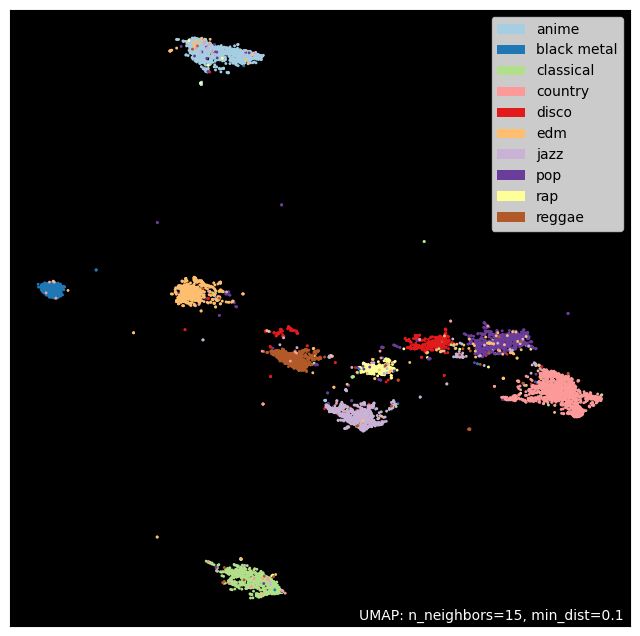

In [456]:
umap.plot.points(manifold1, labels=group_label1, 
              #   theme="viridis", 
                 color_key_cmap='Paired',
                background='black');

In [447]:
y_data.values

array(['disco', 'disco', 'disco', ..., 'country', 'country', 'country'],
      dtype=object)